In [1]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, LambdaCallback, EarlyStopping
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.config.experimental import list_physical_devices, set_virtual_device_configuration, VirtualDeviceConfiguration

gpus = list_physical_devices('GPU')
set_virtual_device_configuration(gpus[0], [VirtualDeviceConfiguration(memory_limit=1200)])
print(len(gpus), "Physical GPUs")

2023-03-10 18:10:16.313004: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


1 Physical GPUs


2023-03-10 18:10:17.207852: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-03-10 18:10:17.208411: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-03-10 18:10:17.235542: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-10 18:10:17.235662: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1650 computeCapability: 7.5
coreClock: 1.62GHz coreCount: 14 deviceMemorySize: 3.81GiB deviceMemoryBandwidth: 178.84GiB/s
2023-03-10 18:10:17.235679: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-03-10 18:10:17.236939: I tensorflow/stream_executor/platform/def

In [2]:
data = glob.glob("Data/GRBalpha/Data_firmware_3/*-*-*_*-*-*_exp*s_sbin*/ch0/rate_multi_ch.txt")
cps, d_dt = [], []
for fname in data:
    with open(fname) as file:
        lines = file.readlines()
        for line in lines[9:]:
            split = line[:-1].split()
            cps.append(float(split[-1]))

for i in range(len(cps)):
    d_dt.append(cps[i] - cps[i-1]) 

            

print("Number of files:",len(data))
print("Number of points:",len(cps))

df = pd.DataFrame(data = d_dt, columns=["rate"])
df

Number of files: 54
Number of points: 463779


,rate
0,29.333
1,3.334
2,4.333
3,-21.000
4,28.667
...,...
463774,-3.000
463775,18.000
463776,1.000
463777,-1.000


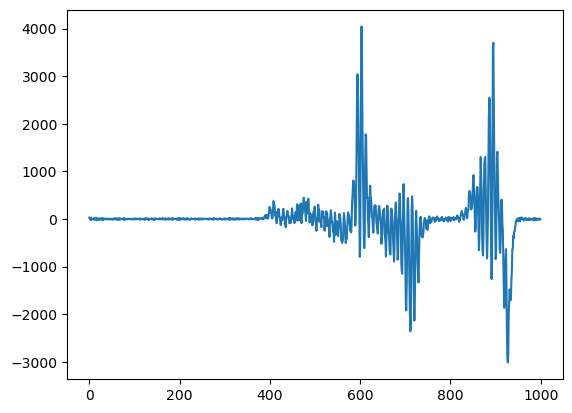

In [3]:
plt.plot(df["rate"][0:1000])

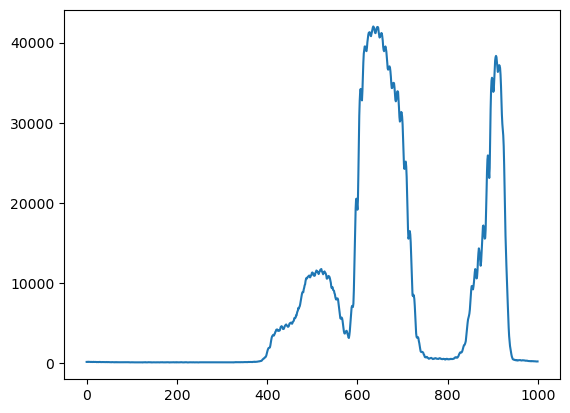

In [6]:
plt.plot(cps[0:1000])

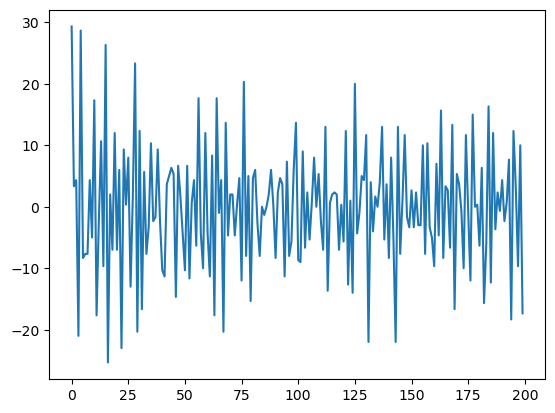

In [4]:
plt.plot(df["rate"][0:200])

In [7]:
df['rate'].to_numpy()

array([ 29.333,   3.334,   4.333, ...,   1.   ,  -1.   , -15.   ])

In [8]:
def df_to_X_y(df, window_size=10):
  df_as_np = df.to_numpy()
  X,y = [], []
  for i in range(len(df_as_np)-window_size):
    X.append(df_as_np[i:i+window_size])
    y.append(df['rate'][i+window_size])
  return np.array(X), np.array(y)

In [9]:
WINDOW_SIZE = 250
X1, y1 = df_to_X_y(df, WINDOW_SIZE)
X1.shape, y1.shape

((463529, 250, 1), (463529,))

In [10]:
X_train, y_train, X_test, y_test = X1[0:400000],y1[0:400000],X1[400000:],y1[400000:]

In [13]:
model1 = Sequential()
model1.add(InputLayer((WINDOW_SIZE, 1)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 64)                16896     
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 520       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


In [14]:
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=RootMeanSquaredError())
model1.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5)

2023-03-10 18:12:29.566685: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 400000000 exceeds 10% of free system memory.


Epoch 1/5


2023-03-10 18:12:30.675638: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-03-10 18:12:30.864489: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


12500/12500 [==============================] - ETA: 0s - loss: 412551.4594 - root_mean_squared_error: 642.2321

2023-03-10 18:13:46.801040: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 63529000 exceeds 10% of free system memory.


12500/12500 [==============================] - 83s 7ms/step - loss: 412551.5258 - root_mean_squared_error: 642.2322 - val_loss: 624115.1250 - val_root_mean_squared_error: 790.0096
Epoch 2/5
12500/12500 [==============================] - 81s 6ms/step - loss: 401309.0496 - root_mean_squared_error: 632.8019 - val_loss: 577698.9375 - val_root_mean_squared_error: 760.0651
Epoch 3/5
12500/12500 [==============================] - 96s 8ms/step - loss: 358851.6540 - root_mean_squared_error: 598.9192 - val_loss: 538755.6875 - val_root_mean_squared_error: 733.9998
Epoch 4/5
12500/12500 [==============================] - 82s 7ms/step - loss: 329014.6399 - root_mean_squared_error: 573.5332 - val_loss: 508775.8438 - val_root_mean_squared_error: 713.2852
Epoch 5/5
12500/12500 [==============================] - 82s 7ms/step - loss: 301429.8710 - root_mean_squared_error: 548.8062 - val_loss: 490327.3125 - val_root_mean_squared_error: 700.2338


In [15]:
#model1.save('models/LSTM_d_dt')

2023-03-10 18:51:05.751434: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: models/LSTM_d_dt/assets


INFO:tensorflow:Assets written to: models/LSTM_d_dt/assets


# GRBalpha (true) detections

In [18]:
data_2 = glob.glob("Data/GRBalpha/Data_firmware_2/*-*-*_*-*-*_exp*s_sbin*/ch0/part*/rate_multi_ch.txt")
cps, d_dt = [], []
for fname in data_2:
    with open(fname) as file:
        lines = file.readlines()
        for line in lines[9:]:
            split = line[:-1].split()
            cps.append(float(split[-1]))

for i in range(len(cps)):
    d_dt.append(cps[i] - cps[i-1]) 

            

print("Number of files:",len(data_2))
print("Number of points:",len(cps))

df_grb = pd.DataFrame(data = d_dt, columns=["rate"])
df_grb

Number of files: 522
Number of points: 173209


,rate
0,4507.00
1,1226.50
2,-1497.50
3,71.25
4,-461.75
...,...
173204,40.75
173205,257.50
173206,-17.50
173207,-156.75


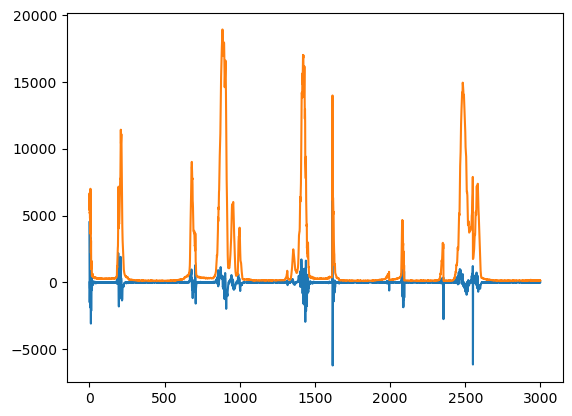

In [22]:
plt.plot(df_grb['rate'][0:3000])
plt.plot(cps[0:3000])

2023-03-10 18:57:35.750069: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 172959000 exceeds 10% of free system memory.


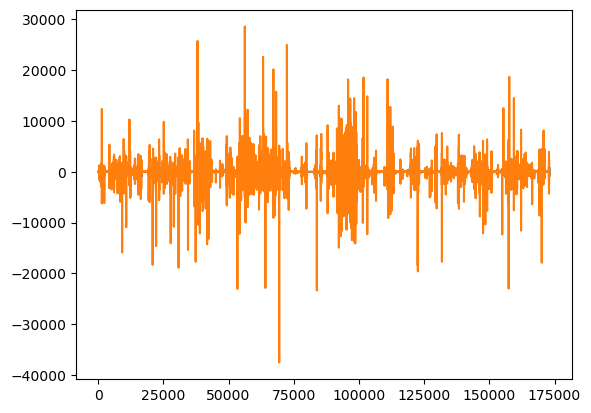

In [27]:
WINDOW_SIZE = 250
X1, y1 = df_to_X_y(df_grb, WINDOW_SIZE)
test_predictions = model1.predict(X1).flatten()
plt.plot((test_predictions))
plt.plot(y1)

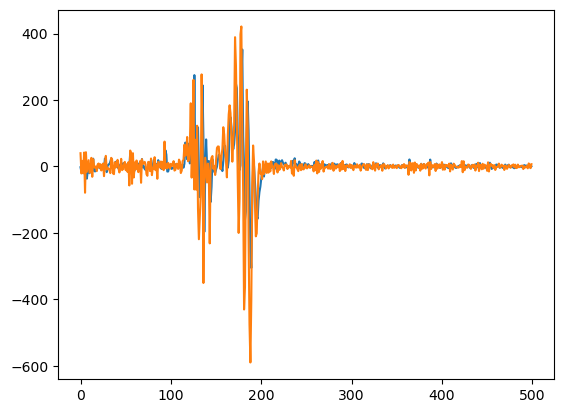

In [28]:
plt.plot((test_predictions[4500:5000]))
plt.plot(y1[4500:5000])

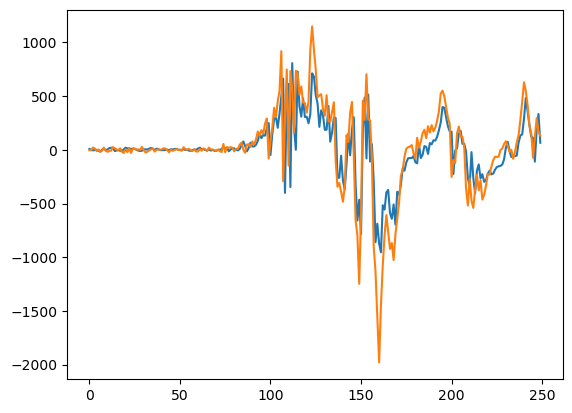

In [30]:
plt.plot((test_predictions[500:750]))
plt.plot(y1[500:750])

/tmp/ipykernel_20698/2009259450.py:1: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot((test_predictions-y1)/y1)


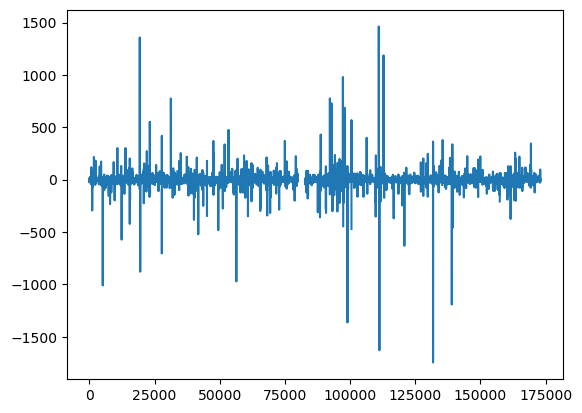

In [31]:
plt.plot((test_predictions-y1)/y1)